In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch
import os
torch.cuda.empty_cache()
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg11
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import copy



def evaluate_model(model, testloader):
 
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def plot_weight_distribution(weight_tensor, title):
   
    plt.figure(figsize=(10, 6))
    plt.hist(weight_tensor.flatten().cpu().numpy(), bins=100)
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model = vgg11(pretrained=True)
model.classifier[6] = nn.Linear(4096, 10)
model.to(device)

print("Initial setup and helper functions are defined.")

tuned_model_path = 'vgg11_cifar10_finetuned.pth'


if os.path.exists(tuned_model_path):
    print(f"Loading existing fine-tuned model from '{tuned_model_path}'...")
 
    model = vgg11()
    model.classifier[6] = nn.Linear(4096, 10)
    model.load_state_dict(torch.load(tuned_model_path))
    model.to(device)
    print("Model loaded.")
else:
    print(f"No fine-tuned model found. Starting the fine-tuning process...")
 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    num_epochs = 5 

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.3f}")

    print('Finished Fine-Tuning.')

    torch.save(model.state_dict(), tuned_model_path)
    print(f"Fine-tuned model saved to '{tuned_model_path}'")



baseline_accuracy = evaluate_model(model, testloader)
print(f'\nAccuracy of the fine-tuned baseline model on the test images: {baseline_accuracy:.2f} %')


Files already downloaded and verified
Files already downloaded and verified
Using device: cuda


d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial setup and helper functions are defined.
Loading existing fine-tuned model from 'vgg11_cifar10_finetuned.pth'...


C:\Users\xylic\AppData\Local\Temp\ipykernel_23580\350945480.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tuned_model_path))


Model loaded.

Accuracy of the fine-tuned baseline model on the test images: 84.61 %



Plotting weight distribution before pruning...


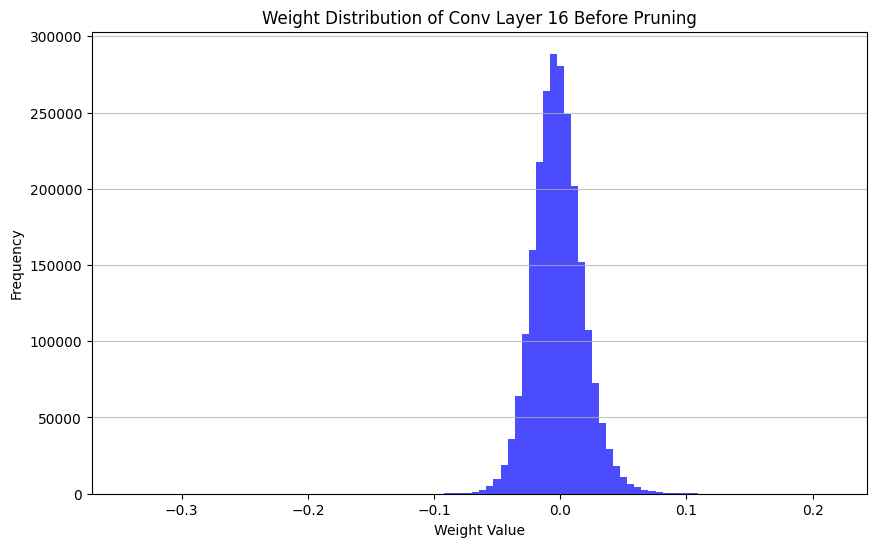

Plotting weight distribution after 50% pruning...


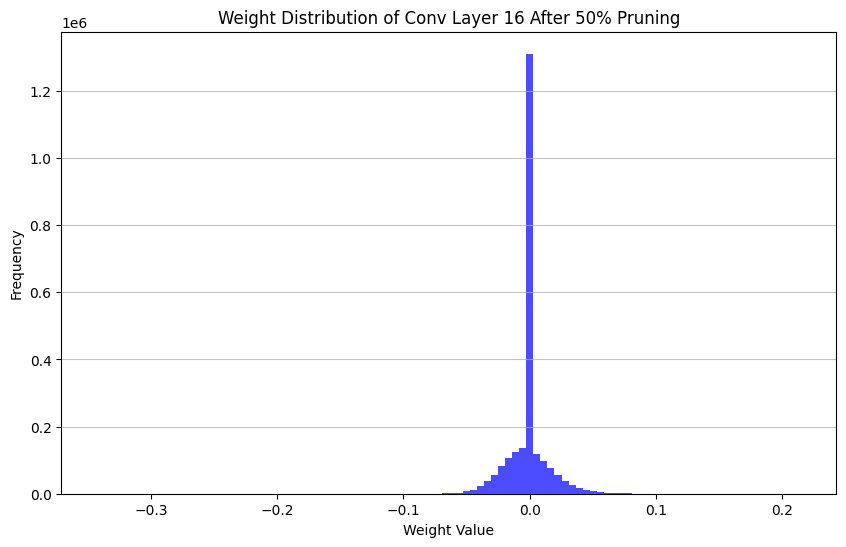

In [ ]:


def plot_weight_distribution(model, layer_index, title):
  
    layer = model.features[layer_index]
    weights = layer.weight.data.cpu().numpy().flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(weights, bins=100, alpha=0.7, color='blue')
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()


CHOSEN_LAYER_IDX = 16


print("\nPlotting weight distribution before pruning...")
plot_weight_distribution(model, CHOSEN_LAYER_IDX, f"Weight Distribution of Conv Layer {CHOSEN_LAYER_IDX} Before Pruning")


temp_pruned_model = copy.deepcopy(model)


layer_to_prune = temp_pruned_model.features[CHOSEN_LAYER_IDX]
l1_norms = torch.sum(torch.abs(layer_to_prune.weight.data), dim=(1, 2, 3))
threshold = torch.quantile(l1_norms, 0.5) 
mask_to_keep = l1_norms >= threshold
layer_to_prune.weight.data *= mask_to_keep.view(-1, 1, 1, 1).float()


print("Plotting weight distribution after 50% pruning...")
plot_weight_distribution(temp_pruned_model, CHOSEN_LAYER_IDX, f"Weight Distribution of Conv Layer {CHOSEN_LAYER_IDX} After 50% Pruning")


Starting sensitivity analysis. This may take a few minutes...
Layer 0, Sparsity 0.1: Accuracy Drop = 0.12%
Layer 0, Sparsity 0.2: Accuracy Drop = 0.63%
Layer 0, Sparsity 0.3: Accuracy Drop = 1.30%
Layer 0, Sparsity 0.4: Accuracy Drop = 2.03%
Layer 0, Sparsity 0.5: Accuracy Drop = 4.56%
Layer 0, Sparsity 0.6: Accuracy Drop = 26.31%
Layer 0, Sparsity 0.7: Accuracy Drop = 43.51%
Layer 0, Sparsity 0.8: Accuracy Drop = 55.57%
Layer 0, Sparsity 0.9: Accuracy Drop = 68.15%
Layer 3, Sparsity 0.1: Accuracy Drop = 0.47%
Layer 3, Sparsity 0.2: Accuracy Drop = 1.55%
Layer 3, Sparsity 0.3: Accuracy Drop = 3.19%
Layer 3, Sparsity 0.4: Accuracy Drop = 18.94%
Layer 3, Sparsity 0.5: Accuracy Drop = 27.49%
Layer 3, Sparsity 0.6: Accuracy Drop = 45.07%
Layer 3, Sparsity 0.7: Accuracy Drop = 56.11%
Layer 3, Sparsity 0.8: Accuracy Drop = 63.60%
Layer 3, Sparsity 0.9: Accuracy Drop = 71.22%
Layer 6, Sparsity 0.1: Accuracy Drop = 0.88%
Layer 6, Sparsity 0.2: Accuracy Drop = 1.41%
Layer 6, Sparsity 0.3: Accu

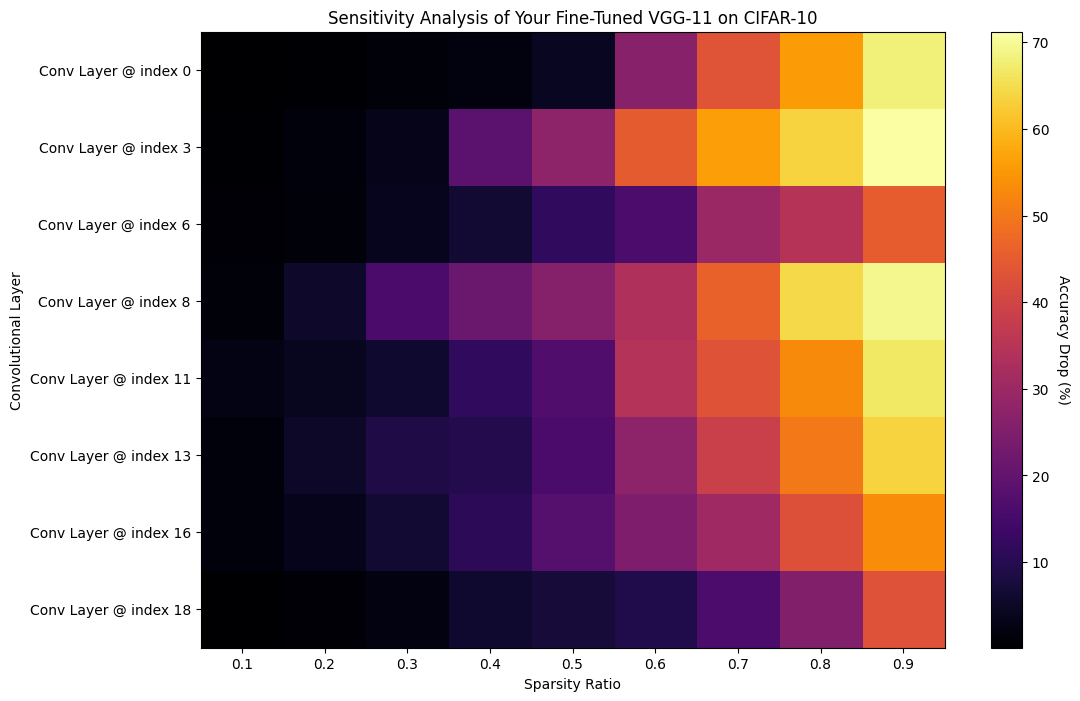

In [ ]:

conv_layer_indices = [i for i, layer in enumerate(model.features) if isinstance(layer, nn.Conv2d)]

def analyze_sensitivity(model, layer_idx, ratio):

    temp_model = copy.deepcopy(model)
    layer = temp_model.features[layer_idx]

    l1_norms = torch.sum(torch.abs(layer.weight.data), dim=(1, 2, 3))
    threshold = torch.quantile(l1_norms, ratio)
    mask_to_keep = l1_norms >= threshold

 
    layer.weight.data *= mask_to_keep.view(-1, 1, 1, 1).float()
    if layer.bias is not None:
        layer.bias.data *= mask_to_keep.float()

    accuracy = evaluate_model(temp_model, testloader)
    return baseline_accuracy - accuracy

print("\nStarting sensitivity analysis. This may take a few minutes...")
sparsity_ratios = np.linspace(0.1, 0.9, 9)
sensitivity_data = np.zeros((len(conv_layer_indices), len(sparsity_ratios)))

for i, layer_idx in enumerate(conv_layer_indices):
    for j, ratio in enumerate(sparsity_ratios):
        accuracy_drop = analyze_sensitivity(model, layer_idx, ratio)
        sensitivity_data[i, j] = accuracy_drop
        print(f"Layer {layer_idx}, Sparsity {ratio:.1f}: Accuracy Drop = {accuracy_drop:.2f}%")


plt.figure(figsize=(12, 8))
plt.imshow(sensitivity_data, cmap='inferno', interpolation='nearest', aspect='auto')
cbar = plt.colorbar()
cbar.set_label('Accuracy Drop (%)', rotation=270, labelpad=15)
plt.xticks(ticks=np.arange(len(sparsity_ratios)), labels=[f'{r:.1f}' for r in sparsity_ratios])
plt.yticks(ticks=np.arange(len(conv_layer_indices)), labels=[f'Conv Layer @ index {i}' for i in conv_layer_indices])
plt.xlabel("Sparsity Ratio")
plt.ylabel("Convolutional Layer")
plt.title("Sensitivity Analysis of Your Fine-Tuned VGG-11 on CIFAR-10")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import copy
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_architecture = models.vgg11(pretrained=False)
num_features = model_architecture.classifier[6].in_features
model_architecture.classifier[6] = nn.Linear(num_features, 10)


model_path = "vgg11_cifar10_finetuned.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Error: The model file '{model_path}' was not found.")
    
model_architecture.load_state_dict(torch.load(model_path))
finetuned_model = model_architecture.to(device)
finetuned_model.eval()



def create_pruned_vgg_model(original_model, sparsity_per_layer):
  
    new_model = copy.deepcopy(original_model)
    conv_layer_indices = [i for i, module in enumerate(original_model.features) if isinstance(module, nn.Conv2d)]
    
    masks = {}

    for layer_idx in conv_layer_indices:
        layer = original_model.features[layer_idx]
        ratio = sparsity_per_layer.get(layer_idx, 0)
        l1_norms = torch.sum(torch.abs(layer.weight.data), dim=(1, 2, 3))
        num_to_keep = int(len(l1_norms) * (1 - ratio))
        indices_to_keep = torch.topk(l1_norms, num_to_keep, largest=True).indices
        masks[layer_idx] = sorted(indices_to_keep.tolist())

    new_features = []
    last_kept_channels_indices = None

    for i, layer in enumerate(original_model.features):
        if isinstance(layer, nn.Conv2d):
            kept_output_channels_indices = masks[i]
            in_channels = len(last_kept_channels_indices) if last_kept_channels_indices is not None else layer.in_channels
            out_channels = len(kept_output_channels_indices)
            new_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding)
            
            kept_weights = layer.weight.data[kept_output_channels_indices, :, :, :]
            kept_biases = layer.bias.data[kept_output_channels_indices]
            
            if last_kept_channels_indices is not None:
                kept_weights = kept_weights[:, last_kept_channels_indices, :, :]

            new_conv.weight.data = kept_weights
            new_conv.bias.data = kept_biases
            new_features.append(new_conv)
            last_kept_channels_indices = kept_output_channels_indices
        elif isinstance(layer, (nn.ReLU, nn.MaxPool2d)):
            new_features.append(copy.deepcopy(layer))

    new_model.features = nn.Sequential(*new_features)


    num_output_channels_last_conv = len(last_kept_channels_indices)
    new_in_features = num_output_channels_last_conv * 7 * 7
    
    old_classifier = original_model.classifier

    new_classifier = nn.Sequential(
        nn.Linear(new_in_features, old_classifier[0].out_features), 
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(old_classifier[3].in_features, old_classifier[3].out_features),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(old_classifier[6].in_features, old_classifier[6].out_features)
    )
   

    new_model.classifier = new_classifier
    
    return new_model




print("\n--- Defining Final Pruning Strategy based on Sensitivity Analysis ---")
sparsity_per_layer = {
    0: 0.10, 3: 0.20, 6: 0.50, 8: 0.60, 11: 0.75, 13: 0.80, 16: 0.85, 18: 0.90,
}
print("Chosen Sparsity Ratios:", sparsity_per_layer)


final_pruned_model = create_pruned_vgg_model(finetuned_model, sparsity_per_layer).to(device)


total_params_original = sum(p.numel() for p in finetuned_model.parameters())
total_params_pruned = sum(p.numel() for p in final_pruned_model.parameters())

compression_ratio = (1 - (total_params_pruned / total_params_original)) * 100

print(f"\n--- CORRECTED Final Pruned Model Results ---")
print(f"Total parameters in original model: {total_params_original:,}")
print(f"Total parameters in pruned model: {total_params_pruned:,}")
print(f"Achieved memory footprint compression: {compression_ratio:.2f}%")


final_model_path = "vgg11_cifar10_structured_pruned_CORRECT.pth"
torch.save(final_pruned_model.state_dict(), final_model_path)
print(f"\nFinal, correctly pruned model saved to: '{final_model_path}'")

C:\Users\xylic\AppData\Local\Temp\ipykernel_23580\3173494511.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_architecture.load_state_dict(torch.load(model_path))



--- Defining Final Pruning Strategy based on Sensitivity Analysis ---
Chosen Sparsity Ratios: {0: 0.1, 3: 0.2, 6: 0.5, 8: 0.6, 11: 0.75, 13: 0.8, 16: 0.85, 18: 0.9}

--- CORRECTED Final Pruned Model Results ---
Total parameters in original model: 128,807,306
Total parameters in pruned model: 27,691,561
Achieved memory footprint compression: 78.50%

Final, correctly pruned model saved to: 'vgg11_cifar10_structured_pruned_CORRECT.pth'
